In [11]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split_augmented import A2CRNNAugmented
from agents.networks.gru_rnn import GRU_RNN
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_session, gen_alignment_chart
from aux_funcs import compressed_write

DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# SUBNETWORK PARAMS
SUB_HIDDEN_SIZE = 32
SUB_INPUT_SIZE = 2
SUB_OUTPUT_SIZE = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\david.bell\work\favorably_connected\code\notebooks


In [3]:
load_path = 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00350.pth'
print(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'))

subnetwork = GRU_RNN(
    input_size=SUB_INPUT_SIZE,
    hidden_size=SUB_HIDDEN_SIZE,
    output_size=SUB_OUTPUT_SIZE,
    device='cpu',
    var_noise=0,
)

network = A2CRNNAugmented(
    subnetwork=subnetwork,
    input_size=OBS_SIZE + ACTION_SIZE + 1,
    action_size=ACTION_SIZE,
    hidden_size=HIDDEN_SIZE,
    device='cpu',
    var_noise=0,
)

with torch.no_grad():
    saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
    if 'network_state_dict' in saved_checkpoint:
        network.load_state_dict(saved_checkpoint['network_state_dict'])
    else:
        network.load_state_dict(saved_checkpoint)
    network.eval()

../../results/rl_agent_outputs/train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00350.pth


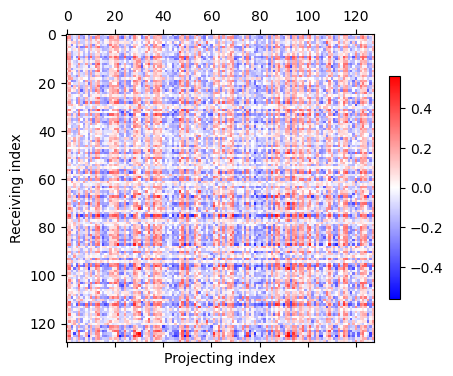

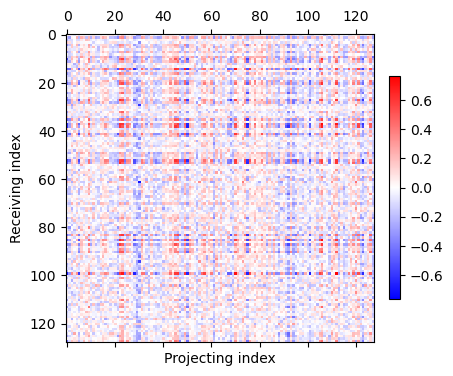

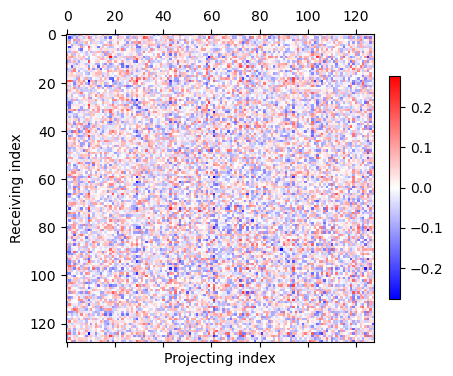

In [3]:
scale = 0.8

w_hh = network.rnn.weight_hh.data.numpy()
m = np.abs(w_hh[:HIDDEN_SIZE, :]).max()

for i in range(3):
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 5 * scale))
    
    m = np.abs(w_hh[i * HIDDEN_SIZE:(i+1) * HIDDEN_SIZE, :]).max()
    cbar = axs.matshow(network.rnn.weight_hh.data.numpy()[i * HIDDEN_SIZE:(i+1) * HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m)
    axs.set_ylabel('Receiving index')
    axs.set_xlabel('Projecting index')
    fig.colorbar(cbar, fraction=0.03, pad=0.04)

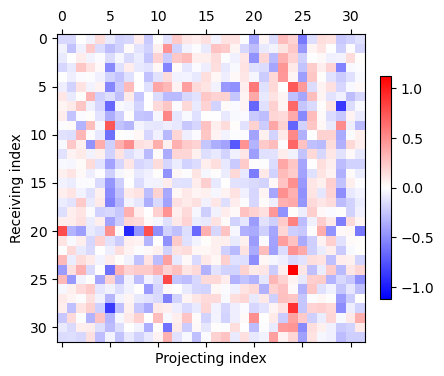

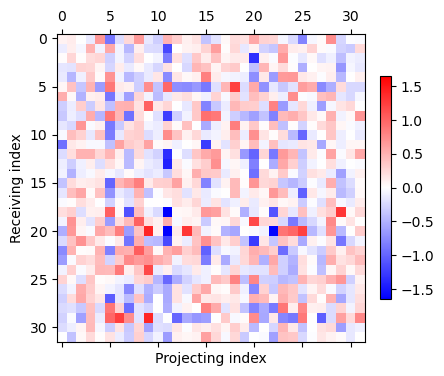

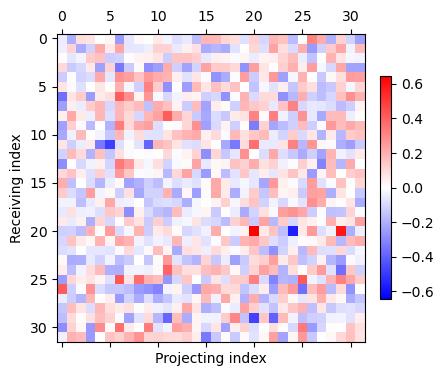

In [4]:
scale = 0.8

w_hh = network.subnetwork.rnn.weight_hh.data.numpy()
m = np.abs(w_hh[:SUB_HIDDEN_SIZE, :]).max()

for i in range(3):
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 5 * scale))
    
    m = np.abs(w_hh[i * SUB_HIDDEN_SIZE:(i+1) * SUB_HIDDEN_SIZE, :]).max()
    cbar = axs.matshow(w_hh[i * SUB_HIDDEN_SIZE:(i+1) * SUB_HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m)
    axs.set_ylabel('Receiving index')
    axs.set_xlabel('Projecting index')
    fig.colorbar(cbar, fraction=0.03, pad=0.04)

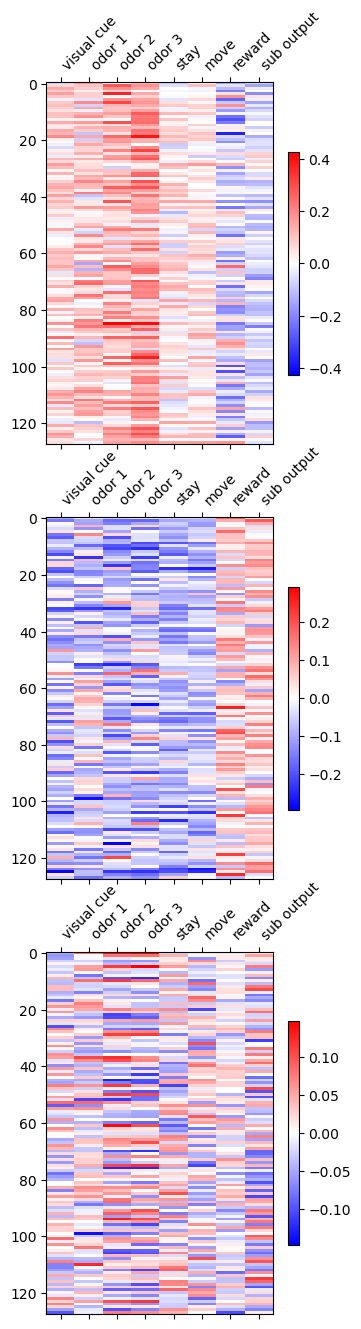

In [5]:
scale = 0.8
fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 20 * scale))

w_ih = network.rnn.weight_ih.data.numpy()

for i in range(3):
    m = np.abs(w_ih[i*HIDDEN_SIZE:(i+1)*HIDDEN_SIZE, :]).max()
    cbar = axs[i].matshow(w_ih[i*HIDDEN_SIZE:(i+1)*HIDDEN_SIZE, :], cmap='bwr', vmin=-m, vmax=m, aspect=0.1)
    axs[i].set_xticks(np.arange(8))
    axs[i].set_xticklabels([
        'visual cue',
        'odor 1',
        'odor 2',
        'odor 3',
        'stay',
        'move',
        'reward',
        'sub output'
    ], rotation=45, ha='left')
    fig.colorbar(cbar, fraction=0.03, pad=0.04)

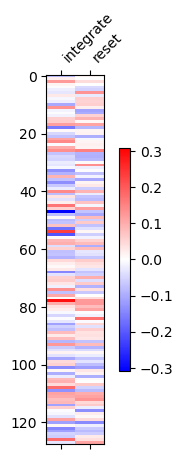

In [7]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 6 * scale))

proj_to_subnetwork = network.proj_to_subnetwork.weight.data.numpy()

m = np.abs(proj_to_subnetwork).max()
cbar = axs.matshow(proj_to_subnetwork.T, cmap='bwr', vmin=-m, vmax=m, aspect=0.1)
axs.set_xticks(np.arange(2))
axs.set_xticklabels([
    'integrate',
    'reset',
], rotation=45, ha='left')
fig.colorbar(cbar, fraction=0.03, pad=0.04)

(2, 128)
(8, 128)
(128,)
[-0.3601841  -0.18021932 -0.38735056 -0.20676002  0.13042873  0.19353822
 -0.06021859 -0.17654303]

(8, 128)
(128,)
[-0.31238908  0.02941895 -0.0970263  -0.15162556  0.10907115  0.0520741
 -0.0332969  -0.39871353]




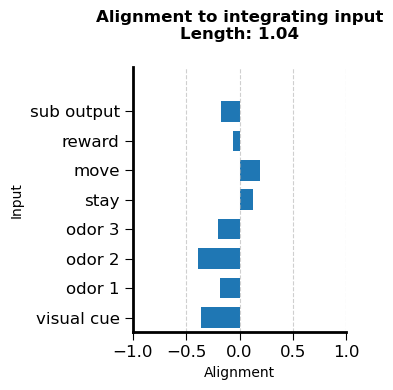

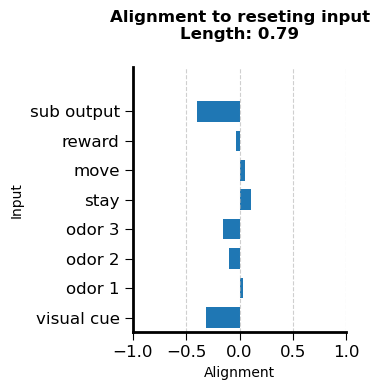

In [15]:
w_ih = network.rnn.weight_ih.data.numpy()

input_weights = w_ih[2 * HIDDEN_SIZE:, :]
proj_to_subnetwork = network.proj_to_subnetwork.weight.data.numpy()

print(proj_to_subnetwork.shape)


fig, axs = gen_alignment_chart(proj_to_subnetwork[0, :], input_weights.T, vlim=9, title='Alignment to integrating input', ylabel='Input', scale=1)
axs[0].set_yticks(np.arange(8))
axs[0].set_yticklabels([
    'visual cue',
    'odor 1',
    'odor 2',
    'odor 3',
    'stay',
    'move',
    'reward',
    'sub output'
], rotation=0, ha='right')
print()

fig, axs = gen_alignment_chart(proj_to_subnetwork[1, :], input_weights.T, vlim=9, title='Alignment to reseting input', ylabel='Input', scale=1)
axs[0].set_yticks(np.arange(8))
axs[0].set_yticklabels([
    'visual cue',
    'odor 1',
    'odor 2',
    'odor 3',
    'stay',
    'move',
    'reward',
    'sub output'
], rotation=0, ha='right')
print()
print()
    

In [13]:
env_idx = 180

data = load_numpy('../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_2025-02-21_09_39_17_295736_var_noise_0_activity_weight_0/hidden_state/*.npy')
data = np.transpose(data, [2, 1, 0])[:128, ...]

print(data.shape)
flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')

pca = PCA()
print(flattened_data.shape)
pc_activities = pca.fit_transform(flattened_data.T)
print('s:', pc_activities.T.shape)
pc_activities = pc_activities.T.reshape(data.shape, order='C')

session_data = parse_session(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_2025-02-21_09_39_17_295736_var_noise_0_activity_weight_0/state',
    env_idx=env_idx % 30,
)

explained_variance_ratios = pca.explained_variance_ratio_

(128, 210, 20000)
(128, 4200000)
s: (128, 4200000)
['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


(2, 128)
(128, 128)
(9, 128)
(128,)
[ 0.46553957  0.49295187 -0.6614718  -0.04043352 -0.19178046 -0.12383598
 -0.11404172  0.00688757  0.02321685]

(9, 128)
(128,)
[-0.5463559   0.09511017  0.304318    0.49823362  0.30427998 -0.41068643
  0.00718735 -0.08277376  0.0923223 ]



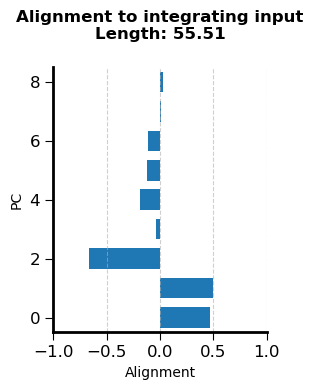

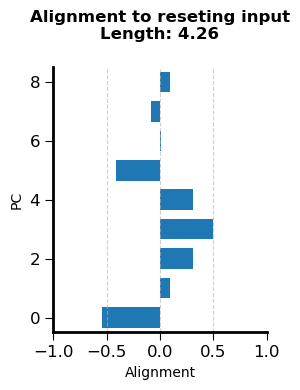

In [12]:
w_ih = network.rnn.weight_ih.data.numpy()

proj_to_subnetwork = network.proj_to_subnetwork.weight.data.numpy()

print(proj_to_subnetwork.shape)

print(pca.components_.shape)

gen_alignment_chart(proj_to_subnetwork[0, :] / proj_to_subnetwork[0, :].sum() , pca.components_, vlim=9, title='Alignment to integrating input', scale=1)
print()

gen_alignment_chart(proj_to_subnetwork[1, :] / proj_to_subnetwork[1, :].sum(), pca.components_, vlim=9, title='Alignment to reseting input', scale=1)
print()

(9, 128)
(128,)
[ 0.36211357  0.18505277 -0.7707378  -0.23052126 -0.04810736  0.2872638
  0.14715971 -0.02242998  0.10669028]
(9, 128)
(128,)
[ 0.18242267  0.54522294 -0.07343306  0.50532883 -0.16012968  0.11153211
 -0.0127135   0.12043409 -0.38987046]
(9, 128)
(128,)
[ 0.56173664  0.70209694  0.16097902 -0.02678494 -0.15198173 -0.29037625
  0.05312346 -0.00982558 -0.18052515]
(9, 128)
(128,)
[ 0.59807515  0.601887    0.44754916 -0.15916048 -0.05629621 -0.06474108
  0.03564695  0.02011415 -0.16369723]
(9, 128)
(128,)
[-0.02288569 -0.24156715  0.15169282  0.25348598  0.04671324 -0.06078444
 -0.14101692 -0.07377845 -0.0474841 ]
(9, 128)
(128,)
[-0.2689013  -0.32251745  0.17990825 -0.16641869  0.00718479 -0.11202489
 -0.05410345  0.14915371  0.01900659]
(9, 128)
(128,)
[-0.22877398  0.07440698 -0.36985895  0.04324462 -0.08893096  0.3837902
 -0.3314132  -0.69864863 -0.12872927]
(9, 128)
(128,)
[ 0.8586929  -0.18835129  0.11305252 -0.32840654 -0.09503797 -0.05586289
  0.09581866 -0.21108565

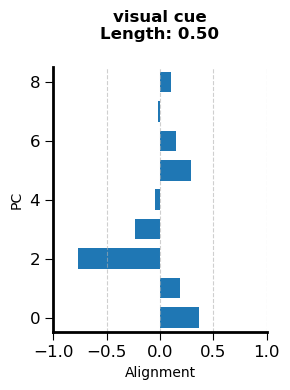

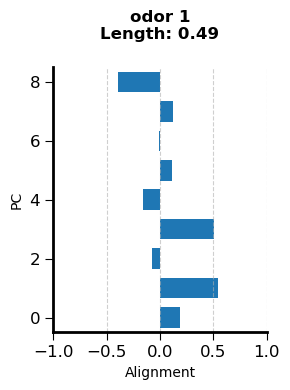

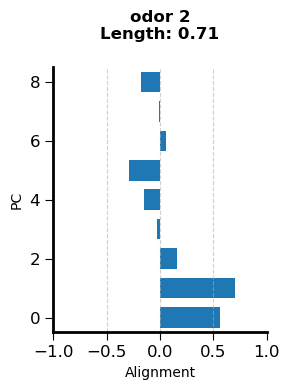

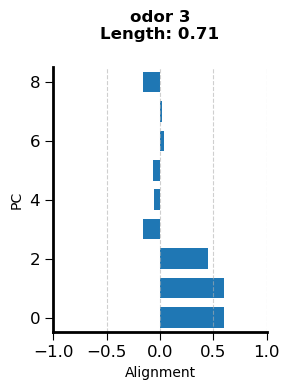

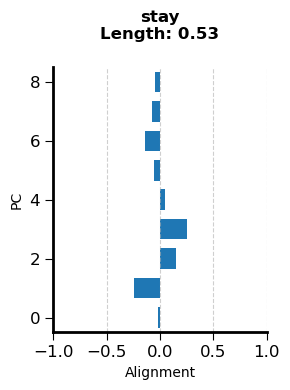

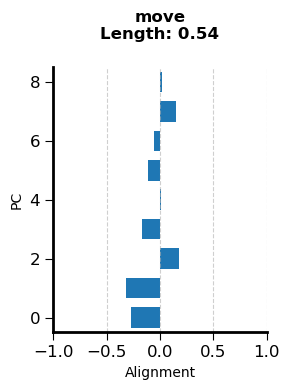

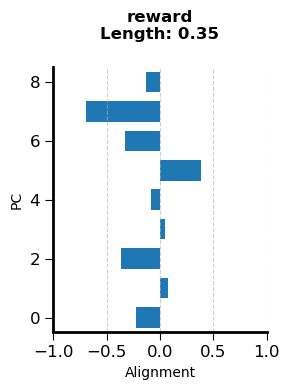

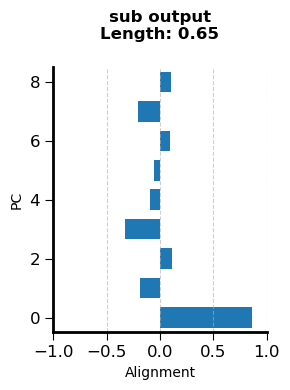

In [16]:
w_ih = network.rnn.weight_ih.data.numpy()

input_weights = w_ih[2 * HIDDEN_SIZE:, :]

titles = [
    'visual cue',
    'odor 1',
    'odor 2',
    'odor 3',
    'stay',
    'move',
    'reward',
    'sub output'
]

for k in range(input_weights.shape[1]):
    gen_alignment_chart(
        input_weights[:, k],
        pca.components_, vlim=9, title=titles[k], ylabel='PC', scale=1)


(128, 128)
(9, 128)
(128,)
[-0.9791768   0.14618492  0.04032261 -0.08431385 -0.06058424 -0.01022567
  0.03127526 -0.00657521 -0.01908896]

(9, 128)
(128,)
[-0.980101    0.14836167  0.03744664 -0.0745758  -0.06003321 -0.0100678
  0.0338463  -0.0033367  -0.01811209]



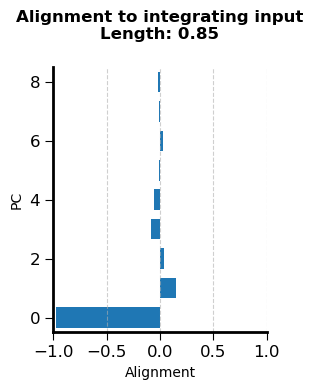

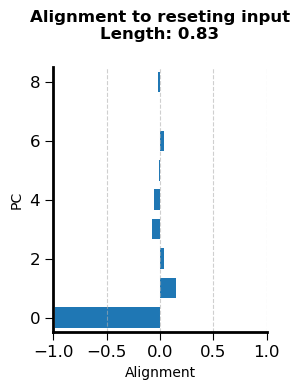

In [9]:
w_action = network.action_arm.weight.detach().numpy()

print(pca.components_.shape)

gen_alignment_chart(w_action[0, :] / w_action[0, :].sum() , pca.components_, vlim=9, title='Alignment to integrating input', scale=1)
print()

gen_alignment_chart(w_action[1, :] / w_action[1, :].sum(), pca.components_, vlim=9, title='Alignment to reseting input', scale=1)
print()

180
(128, 210, 20000)


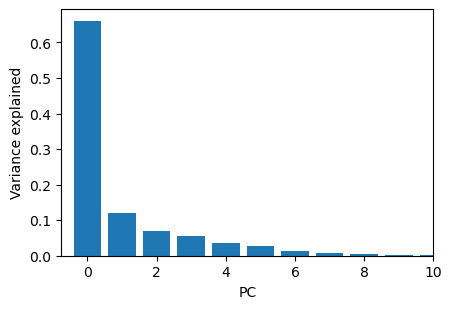

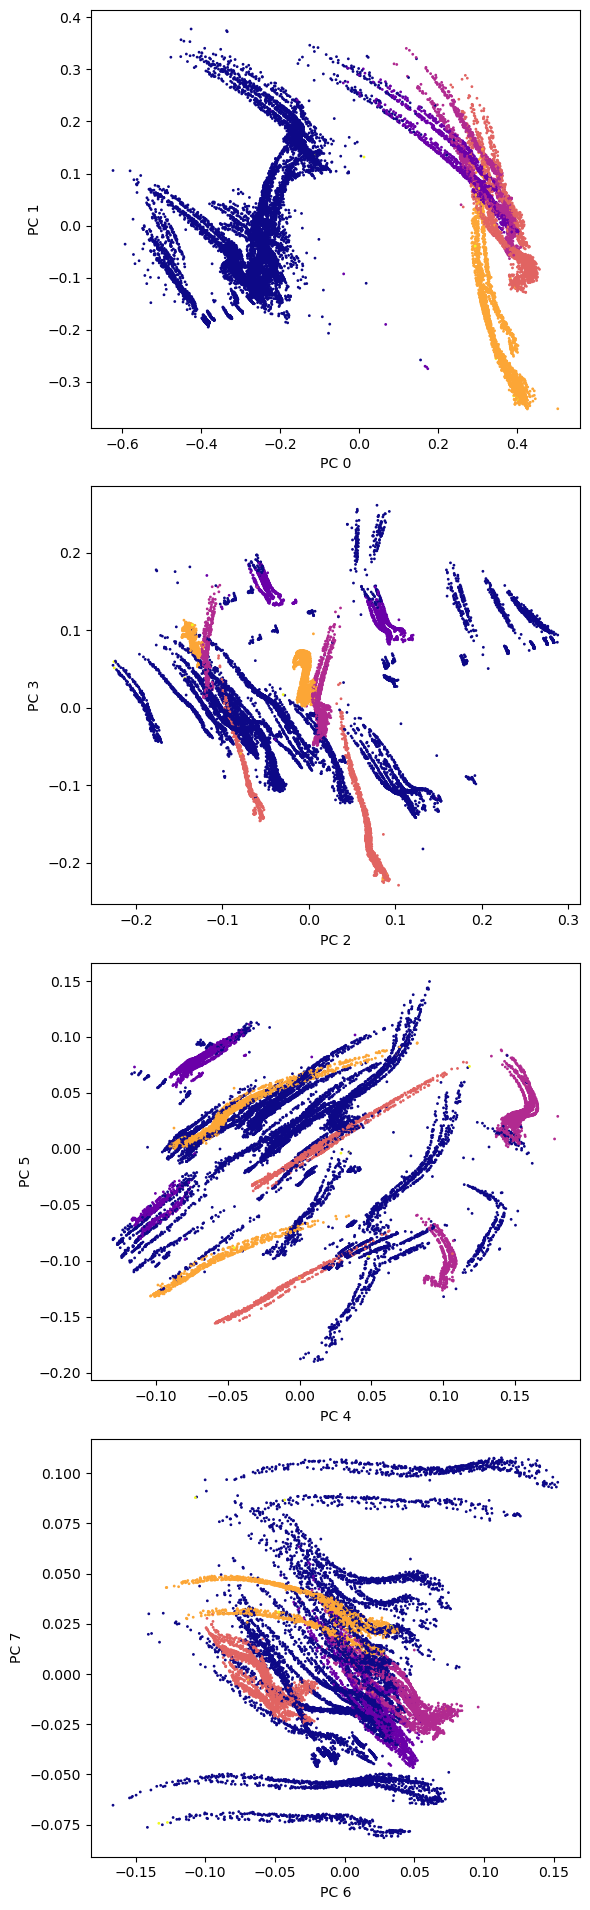

In [30]:
print(env_idx)

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

print(pc_activities.shape)

for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        c=session_data['dwell_time'],
        cmap='plasma',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    # fig.colorbar(cbar)
fig.tight_layout()

180
(128, 210, 20000)


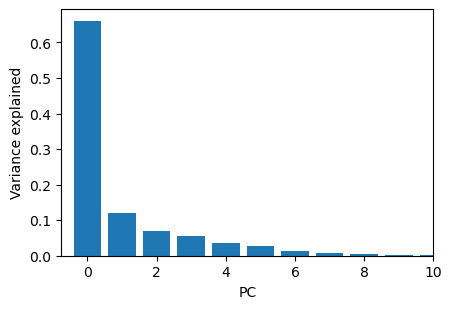

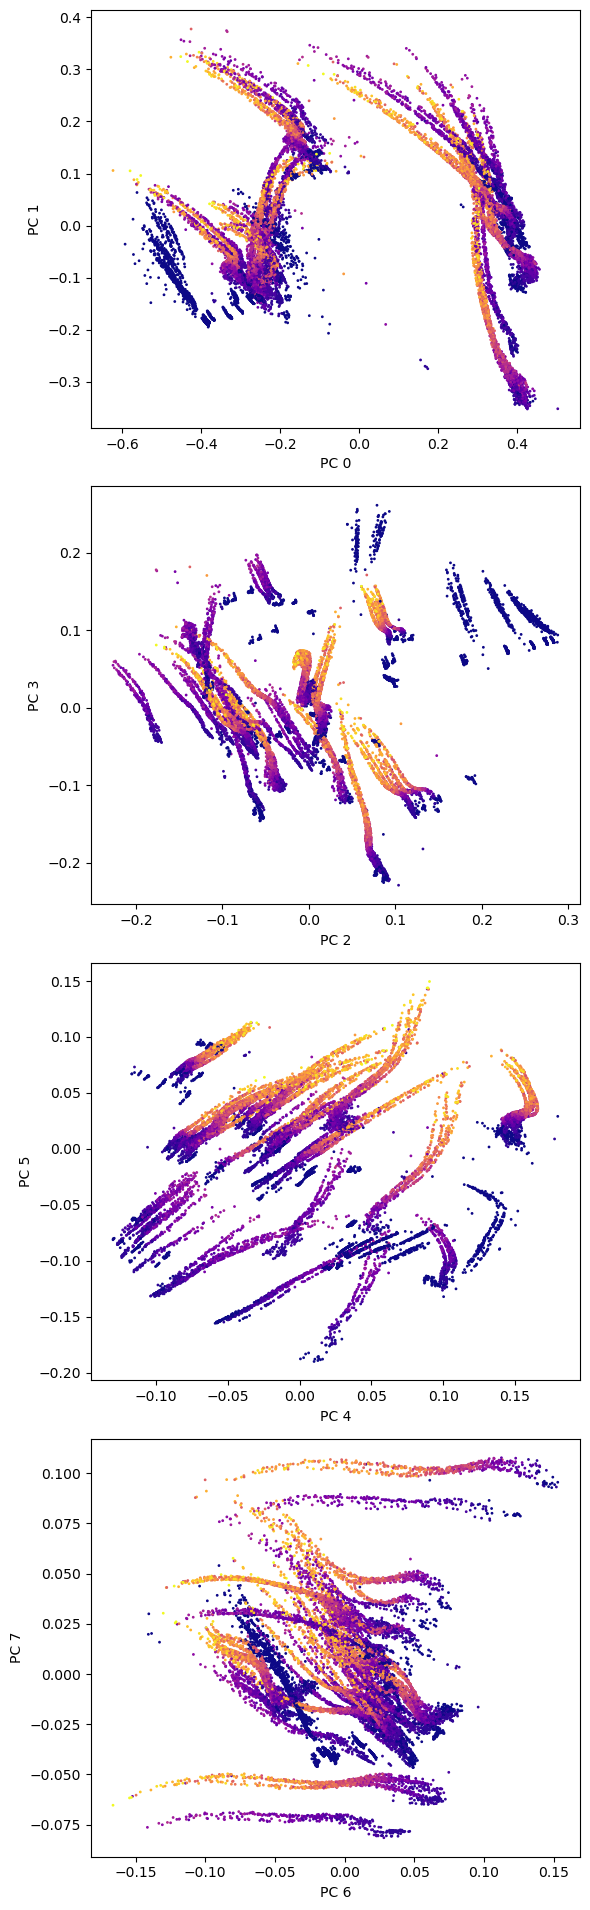

In [32]:
print(env_idx)

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

print(pc_activities.shape)

for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        c=session_data['rewards_seen_in_patch'],
        cmap='plasma',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    # fig.colorbar(cbar)
fig.tight_layout()

180
(128, 210, 20000)


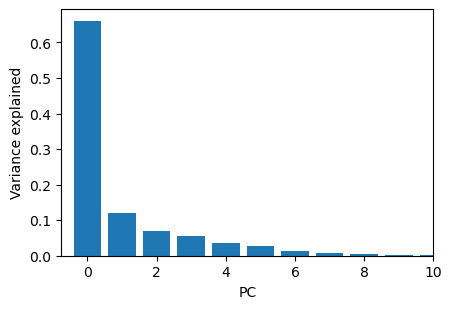

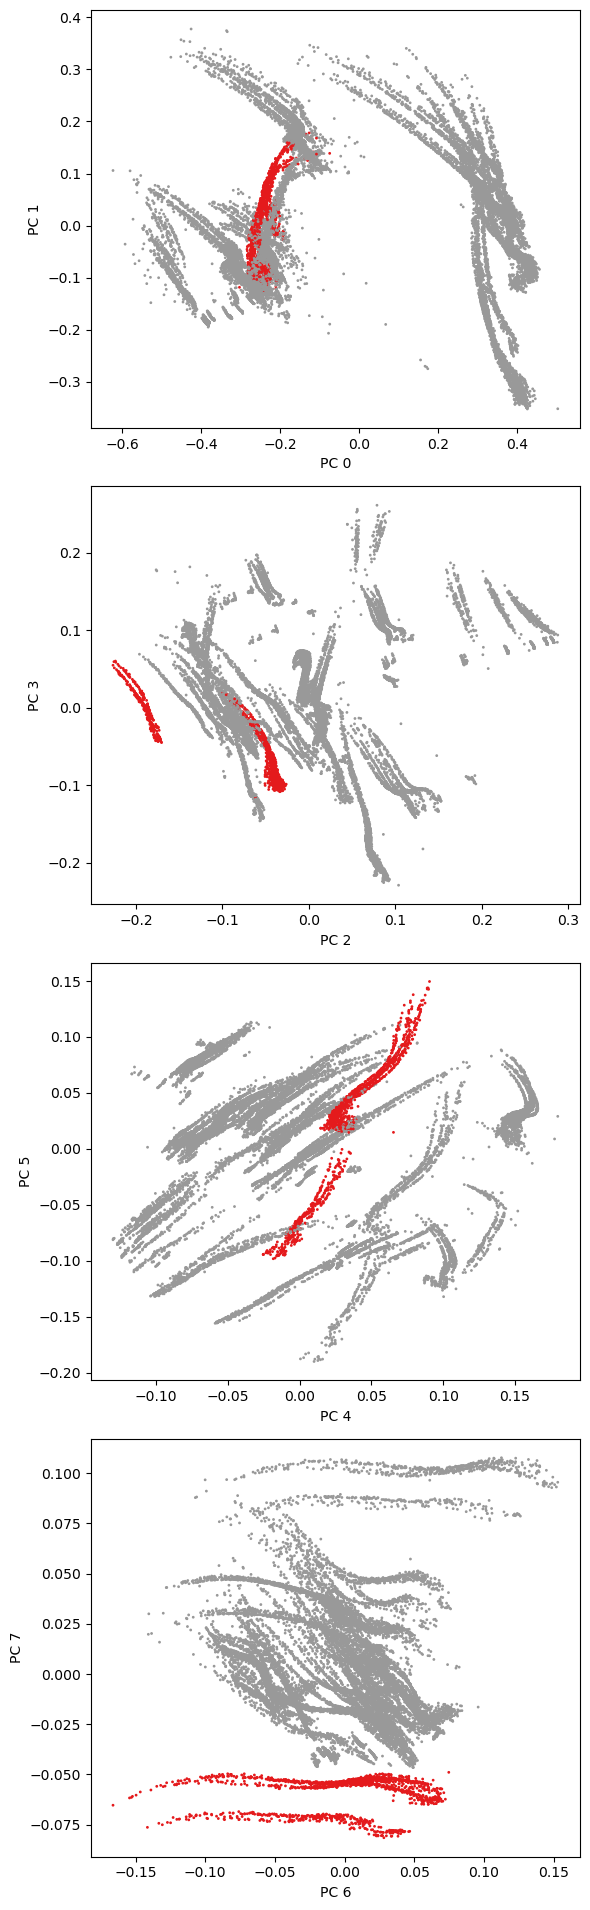

In [27]:
print(env_idx)

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

print(pc_activities.shape)

for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        c=np.roll(session_data['reward'], 1),
        cmap='Set1_r',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    # fig.colorbar(cbar)
fig.tight_layout()

180
(128, 210, 20000)


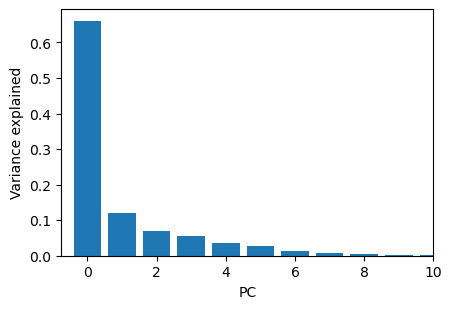

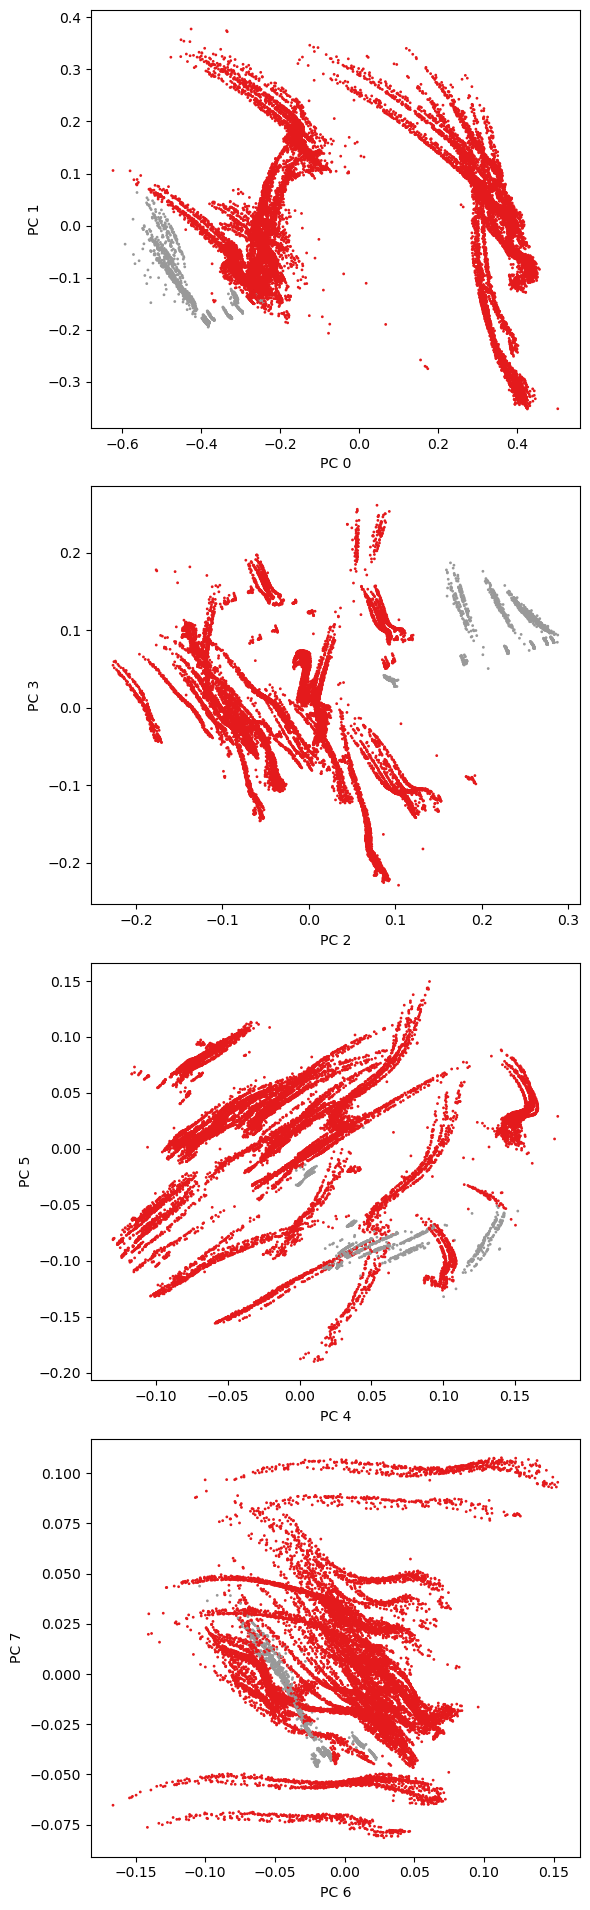

In [29]:
print(env_idx)

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

print(pc_activities.shape)

for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        c=np.roll(session_data['agent_in_patch'], 1),
        cmap='Set1_r',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    # fig.colorbar(cbar)
fig.tight_layout()

In [32]:
fpf_hps = {
		'max_iters': 100000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


[-0.6260625  -0.10993828  0.2349005   0.28204596  0.36149344 -0.04654245
 -0.0267085   0.0570225 ]

[-0.56895435  0.00847526  0.20014589 -0.20822188 -0.00910181  0.07843878
  0.00163356  0.21581194]

[ 0.2516006   0.18298793 -0.046542   -0.16579126  0.42650878  0.06603222
  0.16933142  0.08879066]

[-0.47042888  0.7316199   0.19982782 -0.04943911  0.00684512  0.04191421
  0.08424217  0.07930289]

[ 0.14526278 -0.5956429   0.2627918   0.08496704  0.01236247  0.0950331
  0.08208652  0.18778998]

[-0.15728343 -0.33718532  0.24975415 -0.18091977  0.11000313  0.14661232
  0.04477361  0.15567257]

[-6.3043481e-01 -2.4156999e-03 -4.3611228e-04  1.5768701e-02
 -5.1363625e-02 -9.1531619e-02  8.1273317e-02  8.7460786e-02]

[ 0.83783305  0.0446054   0.12201639 -0.006153    0.23291948 -0.00402697
  0.03205383  0.0552014 ]

[ 0.6207361   0.26610965 -0.00624803 -0.02673099  0.28736877 -0.05753948
 -0.08353103  0.06238984]

[ 0.41997522 -0.12521653 -0.0092357  -0.15660973  0.28912595 -0.06797954
 -0.

C:\Users\david.bell\AppData\Local\Temp\ipykernel_30416\4035400890.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1, figsize=(width, 4 * scale), sharex=True, sharey=True)


[-0.6555443   0.00322323 -0.00189017  0.4374113   0.24886218 -0.12999256
 -0.11124983 -0.00864423]

[0.8156098  0.24726063 0.06934216 0.13173135 0.1935936  0.07301675
 0.10274266 0.08040585]

[-0.7113105   0.32617438  0.20951398  0.01284956  0.16705038  0.03186501
 -0.03895276  0.02822012]

[ 0.83858585  0.2720188   0.17955266  0.14862053  0.03651658 -0.00418362
  0.04150521  0.05499423]

[ 0.8188163   0.32141048  0.17709954  0.17905928 -0.05870926  0.05789724
  0.06398915  0.06771871]

[ 0.26737815 -0.54572177  0.26322076  0.12892479  0.08609507  0.08211645
  0.07905702  0.17394729]

[ 0.09538926 -0.14568989  0.24575159 -0.05047751  0.16506645  0.09756718
  0.0317288   0.11142884]

[0.92100644 0.0927545  0.00393546 0.2040886  0.1474337  0.02137947
 0.04452996 0.0392608 ]

[-0.38941717 -0.35255748  0.25962868  0.32941642  0.31203613  0.00694142
  0.02620032  0.06051569]

[-0.1595425  -0.4217683   0.30381048  0.1330214  -0.01940759  0.10024794
  0.11180443  0.14548323]

[ 0.03761099 -0.

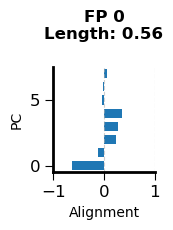

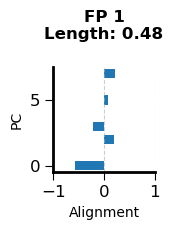

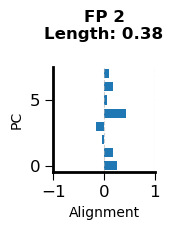

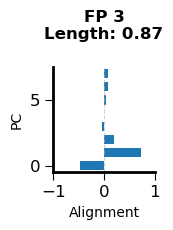

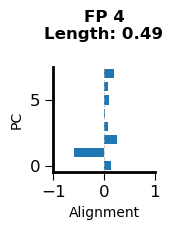

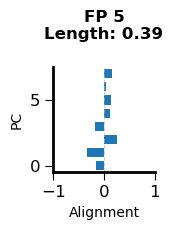

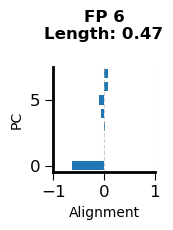

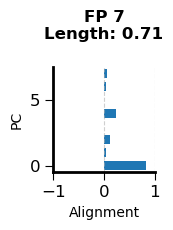

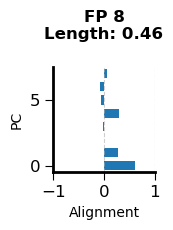

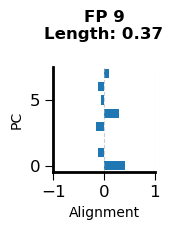

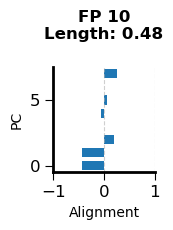

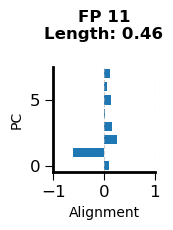

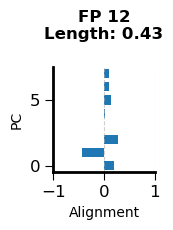

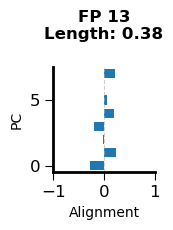

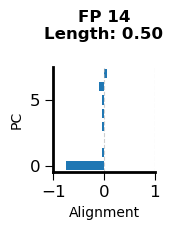

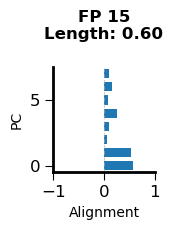

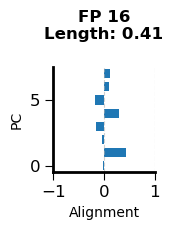

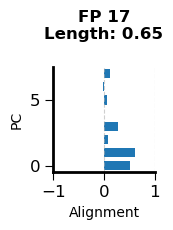

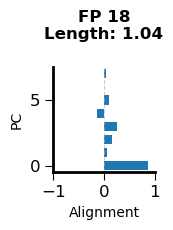

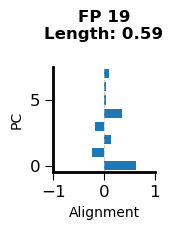

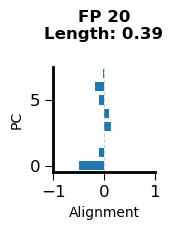

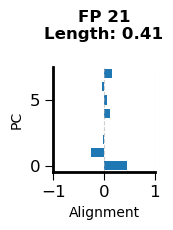

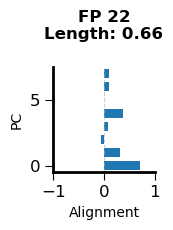

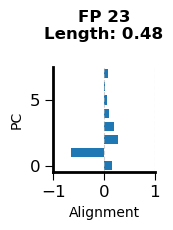

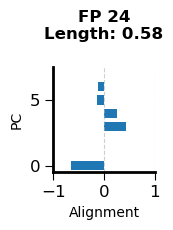

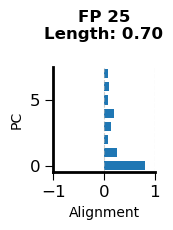

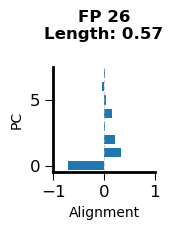

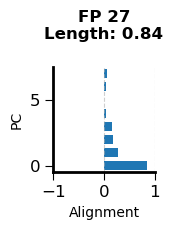

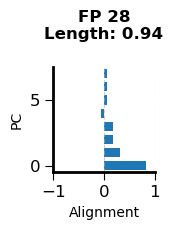

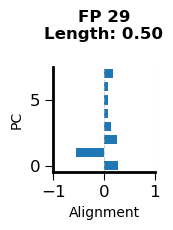

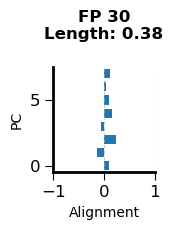

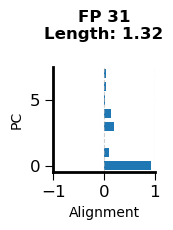

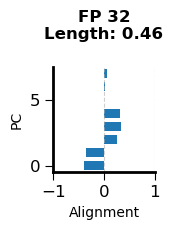

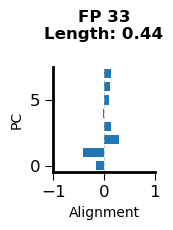

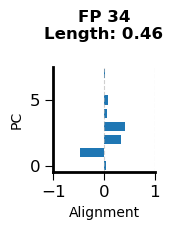

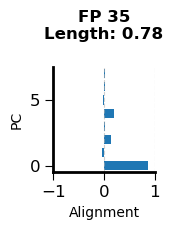

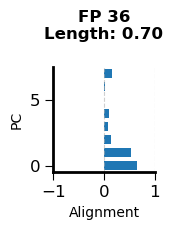

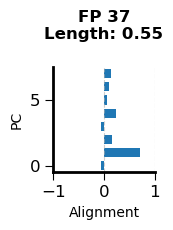

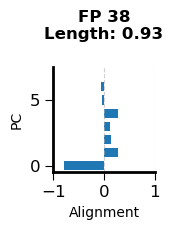

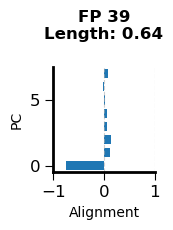

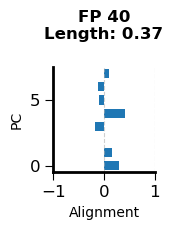

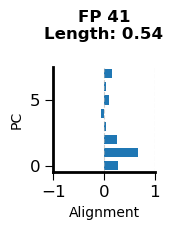

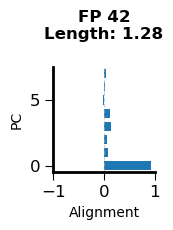

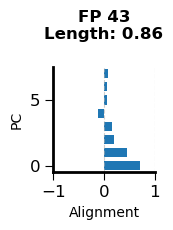

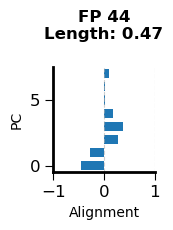

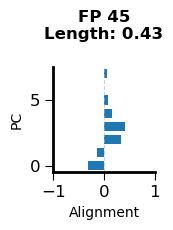

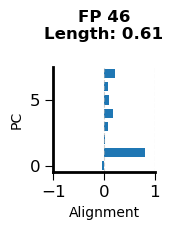

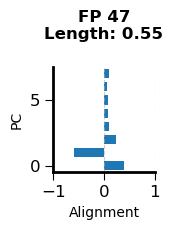

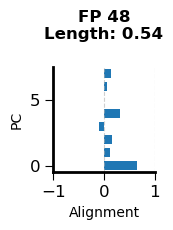

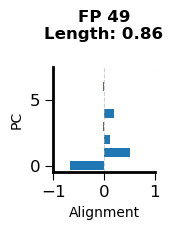

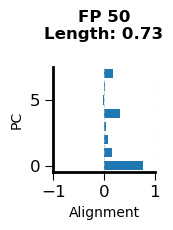

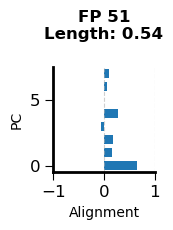

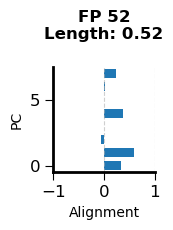

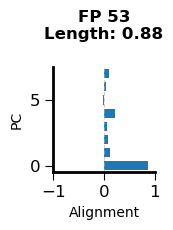

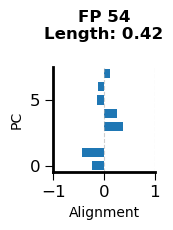

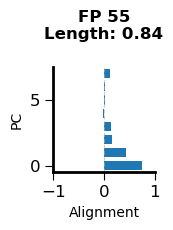

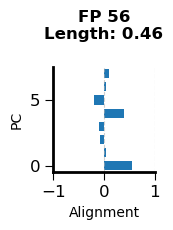

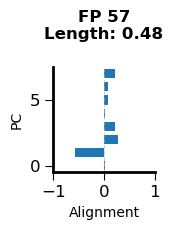

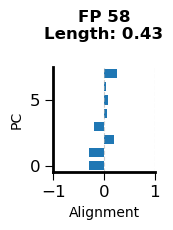

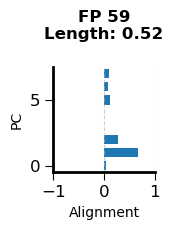

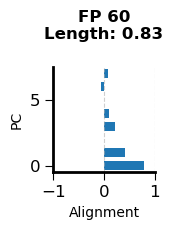

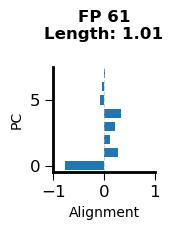

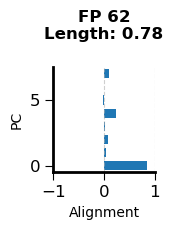

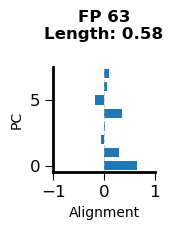

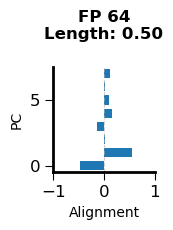

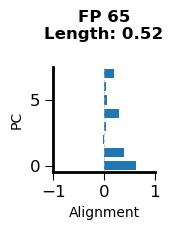

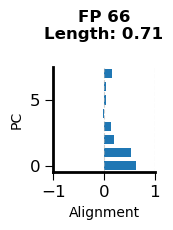

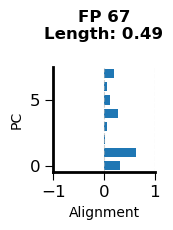

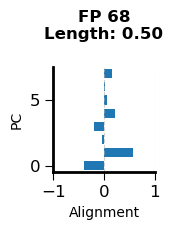

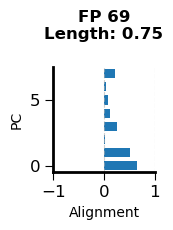

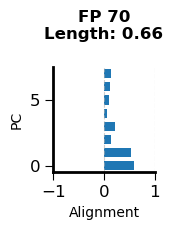

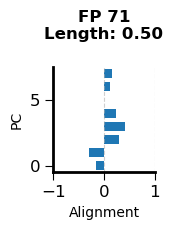

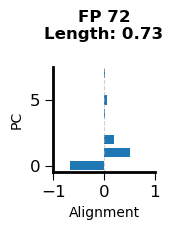

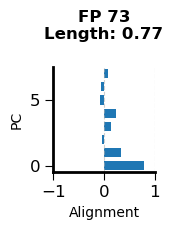

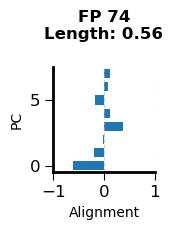

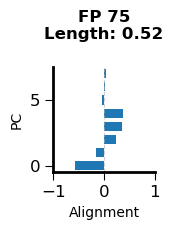

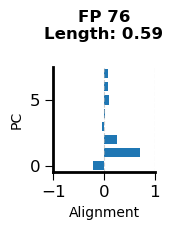

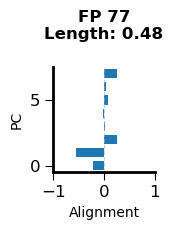

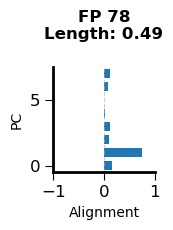

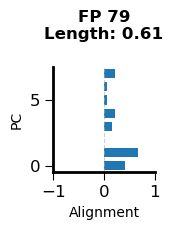

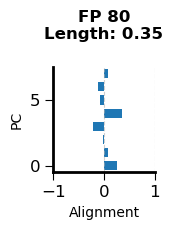

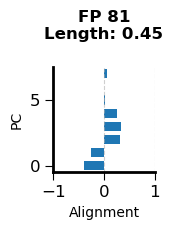

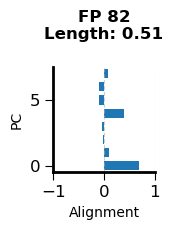

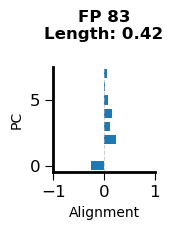

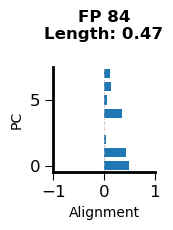

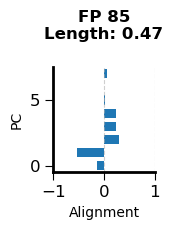

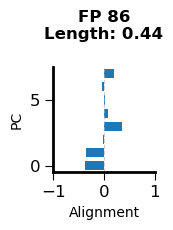

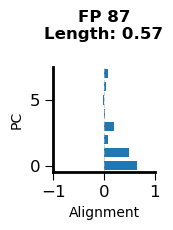

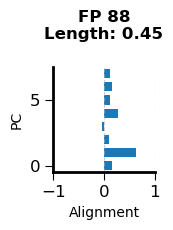

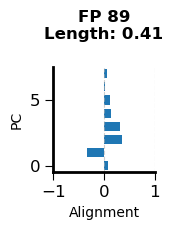

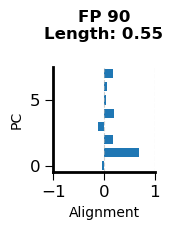

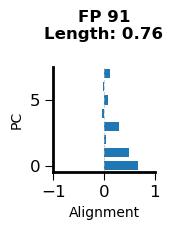

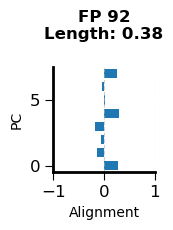

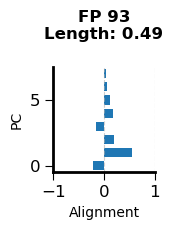

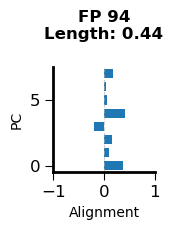

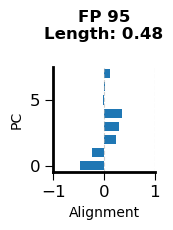

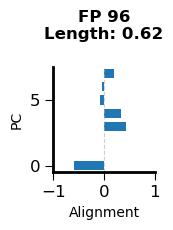

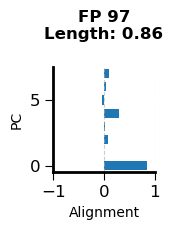

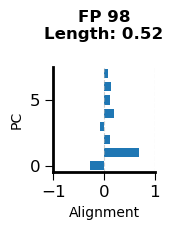

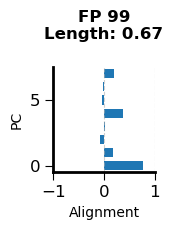

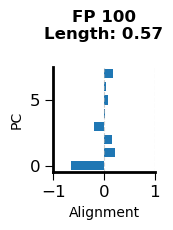

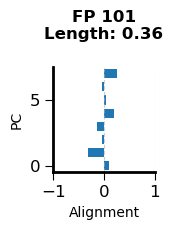

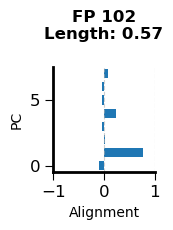

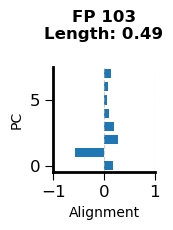

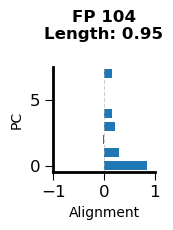

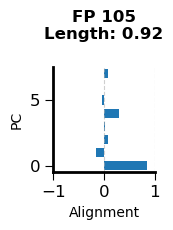

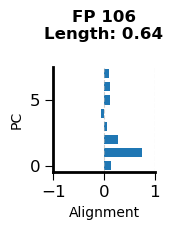

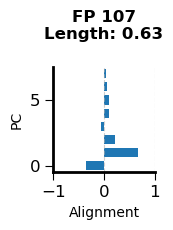

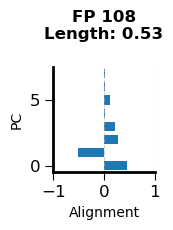

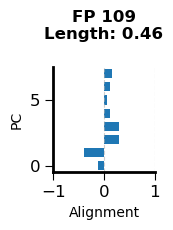

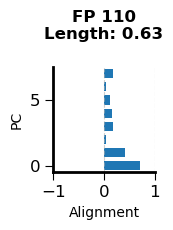

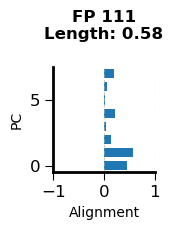

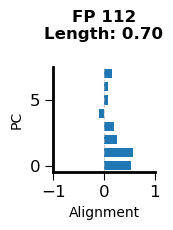

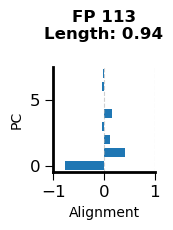

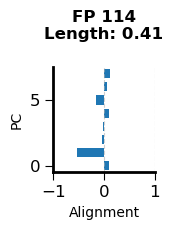

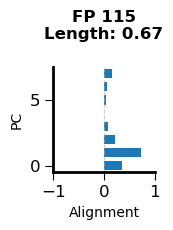

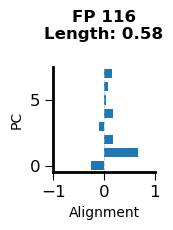

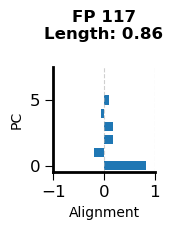

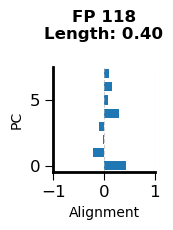

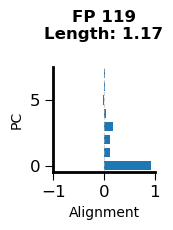

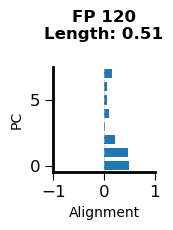

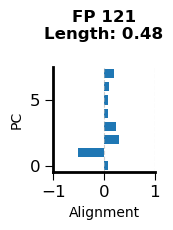

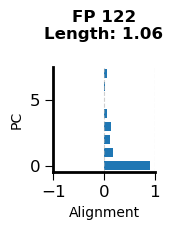

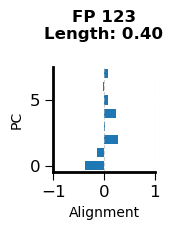

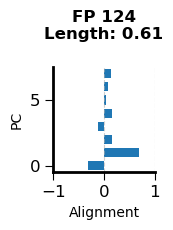

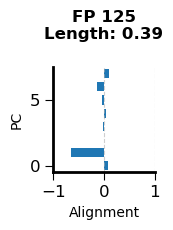

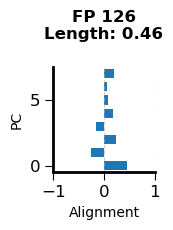

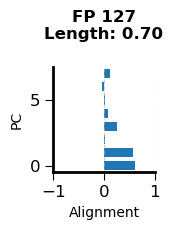

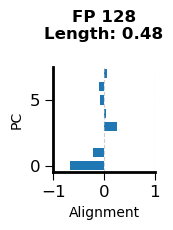

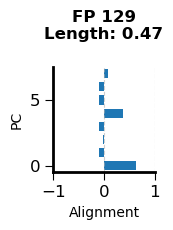

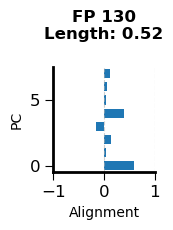

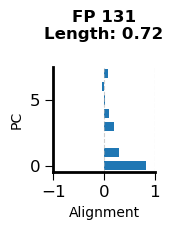

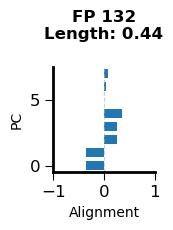

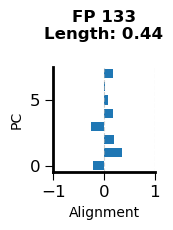

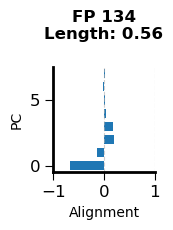

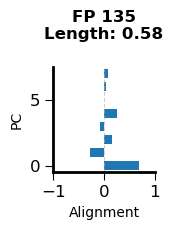

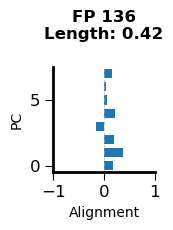

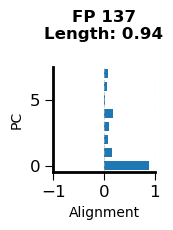

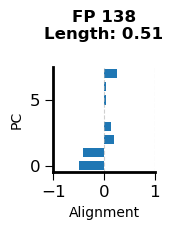

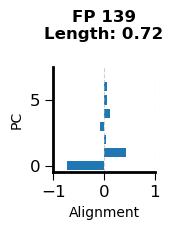

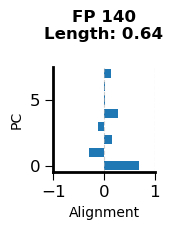

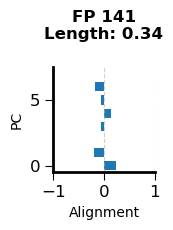

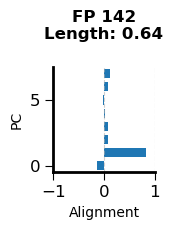

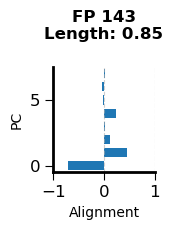

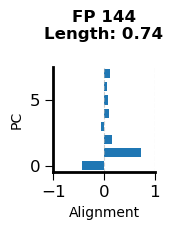

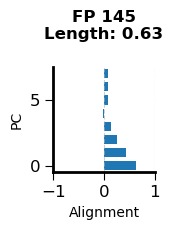

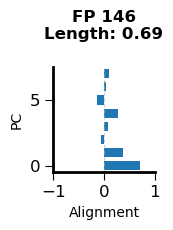

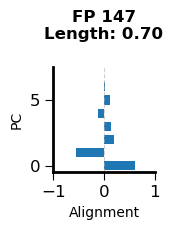

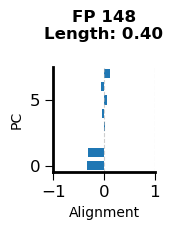

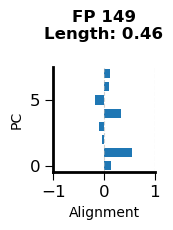

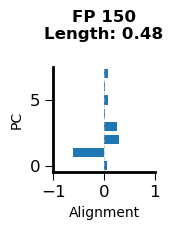

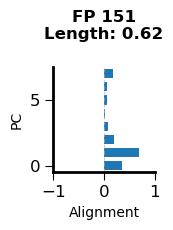

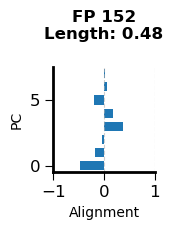

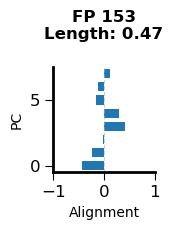

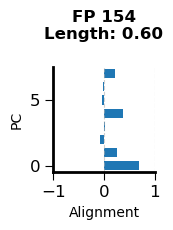

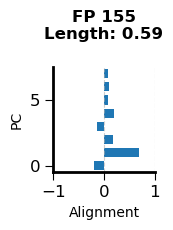

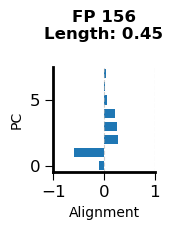

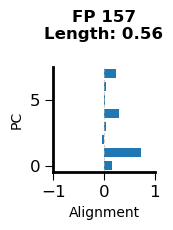

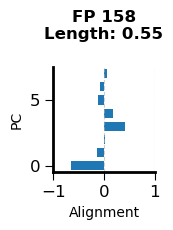

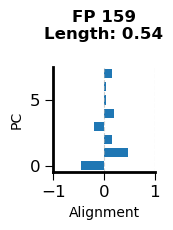

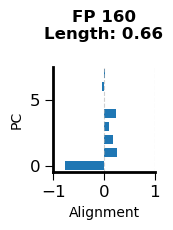

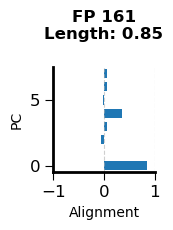

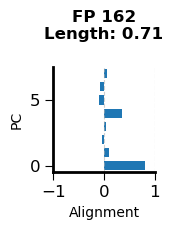

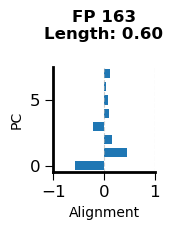

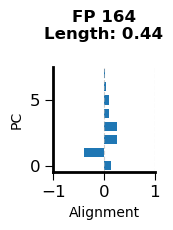

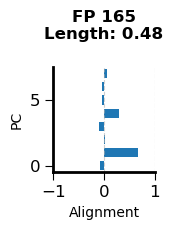

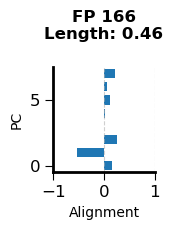

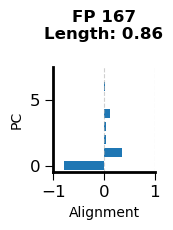

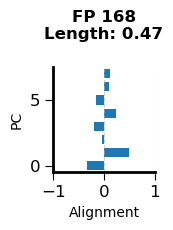

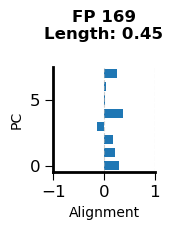

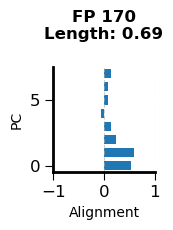

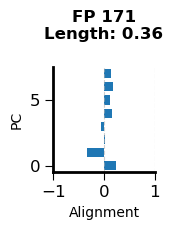

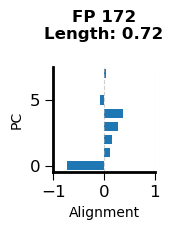

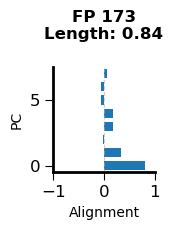

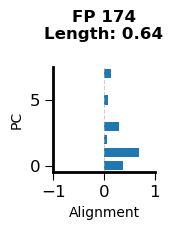

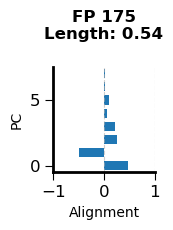

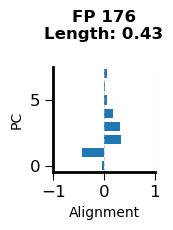

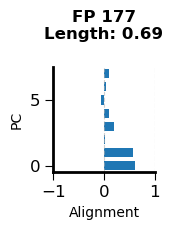

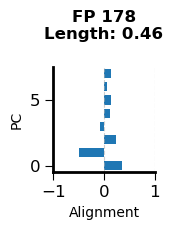

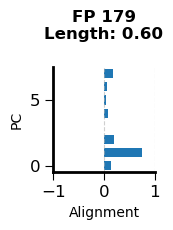

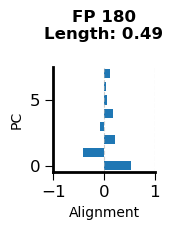

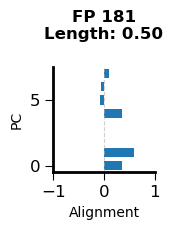

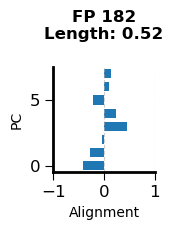

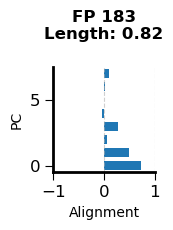

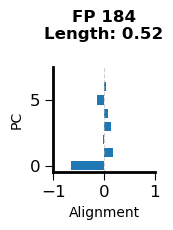

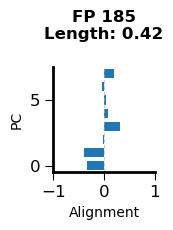

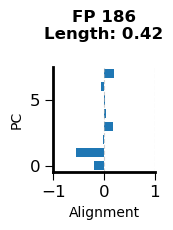

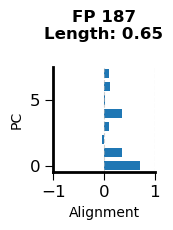

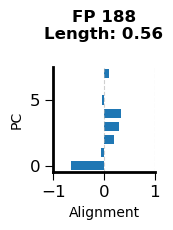

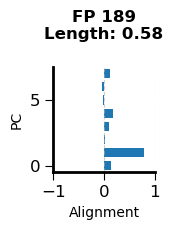

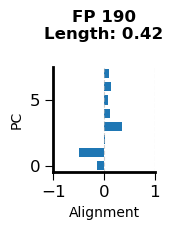

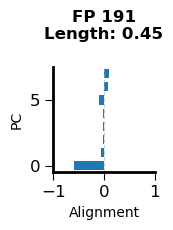

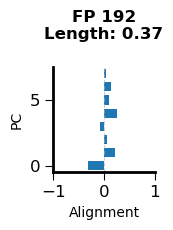

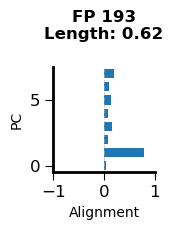

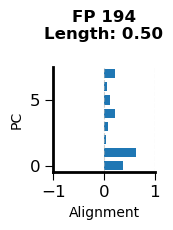

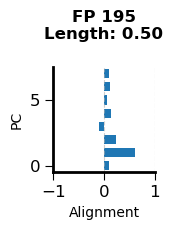

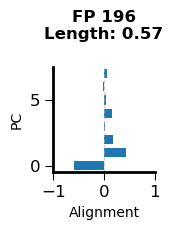

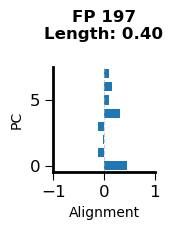

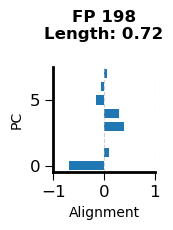

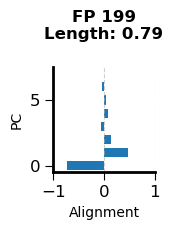

In [14]:
for i_f in range(unique_fps.xstar.shape[0]):
    fp_i = unique_fps.xstar[i_f, :]
    gen_alignment_chart(fp_i, pca.components_, vlim=8, title=f'FP {i_f}')
    print()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


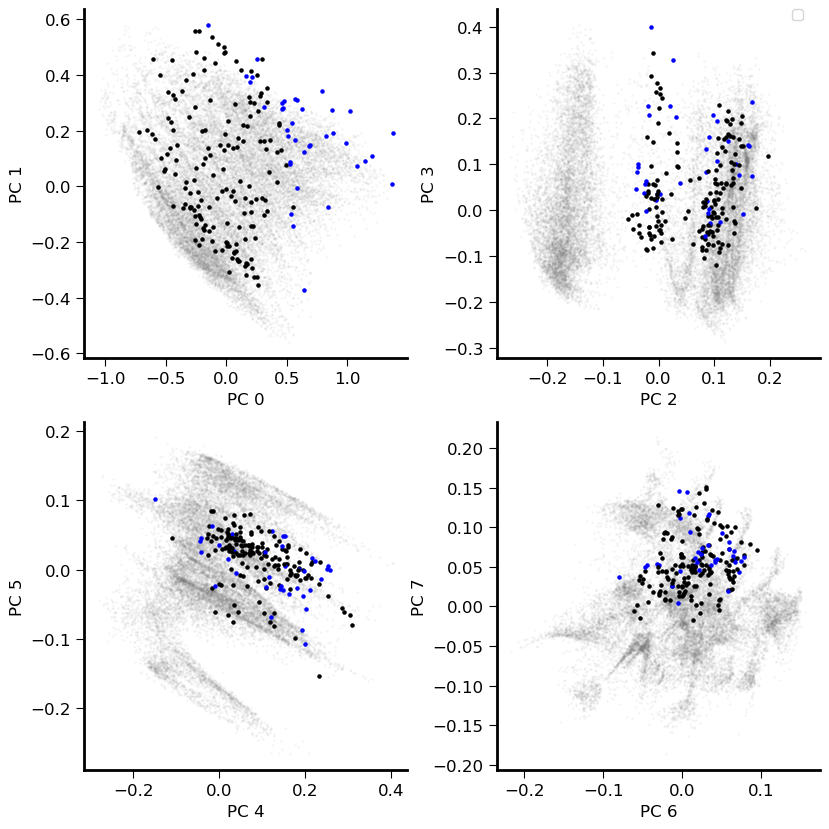

In [35]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=5,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}', fontsize=12)
    axs[k_x, k_y].set_ylabel(f'PC {k+1}', fontsize=12)

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)

    axs[k_x, k_y].tick_params(axis='both', labelsize=12, length=6)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

In [46]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


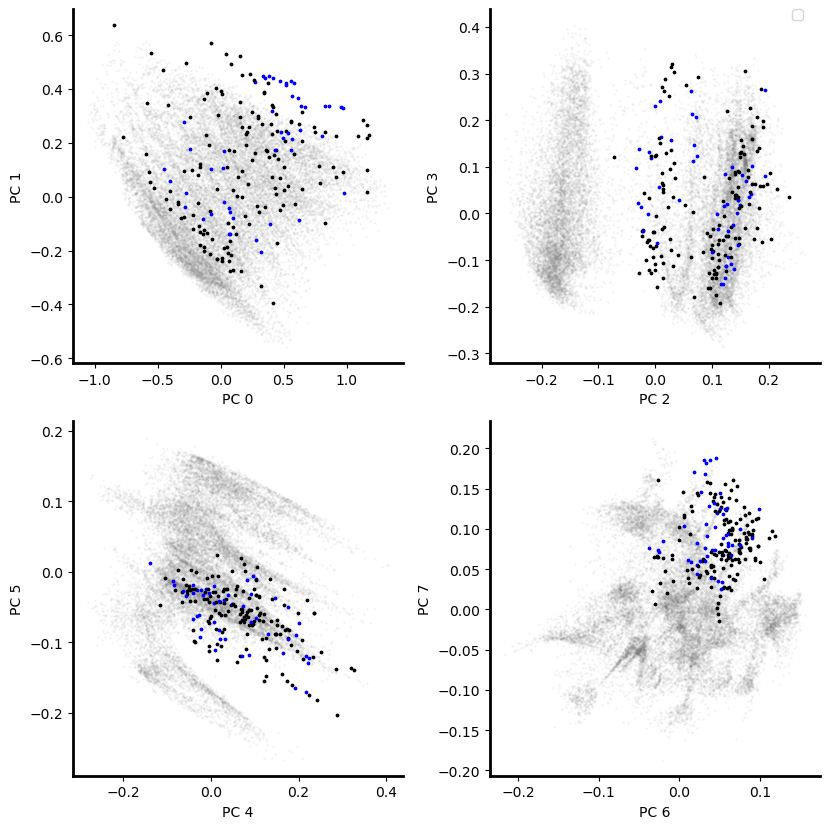

In [47]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=3,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

In [9]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 0.5
inputs[:, 2] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


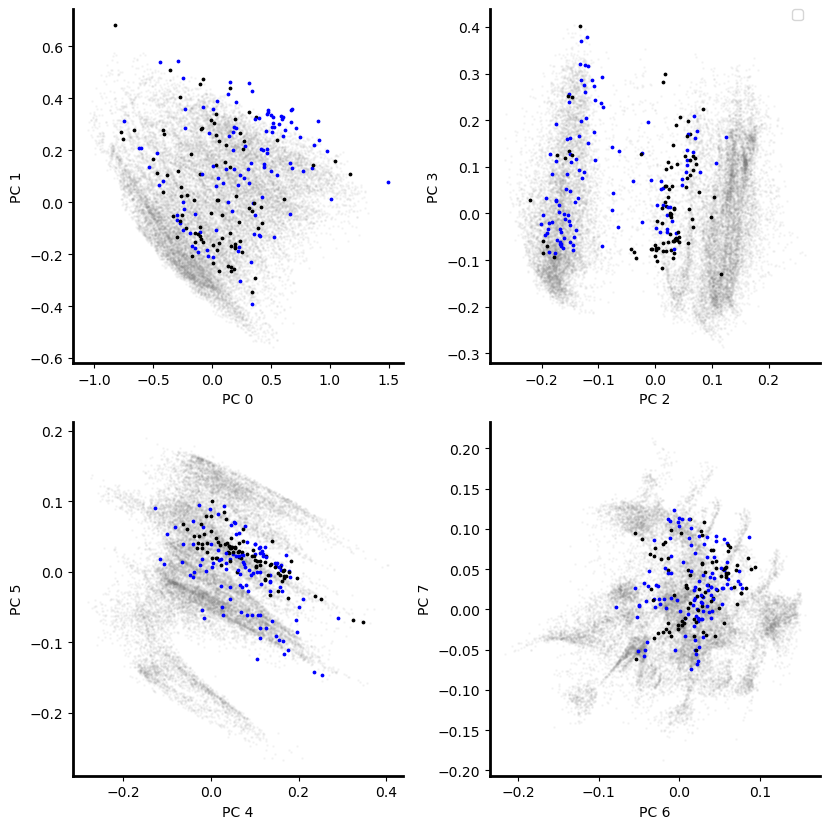

In [10]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=3,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()

In [6]:
fpf_hps = {
		'max_iters': 50000,
		'lr_init': 1e-6,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
}
network.rnn.batch_first = True
fpf = FixedPointFinder(network.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
inputs[:, 2] = 1
samples = np.zeros(flattened_data.shape[1]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = flattened_data[:, samples].T
# for i in np.linspace(-1, 1, 10):
#     for j in np.linspace(-0.5, 0.5, 10):
#         initial_states.append(i * pca.components_[0, :] + j * pca.components_[1, :] + 0.1 * pca.components_[2, :])

initial_states = np.array(initial_states)
print(initial_states.shape)

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

print(unique_fps)

(200, 128)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


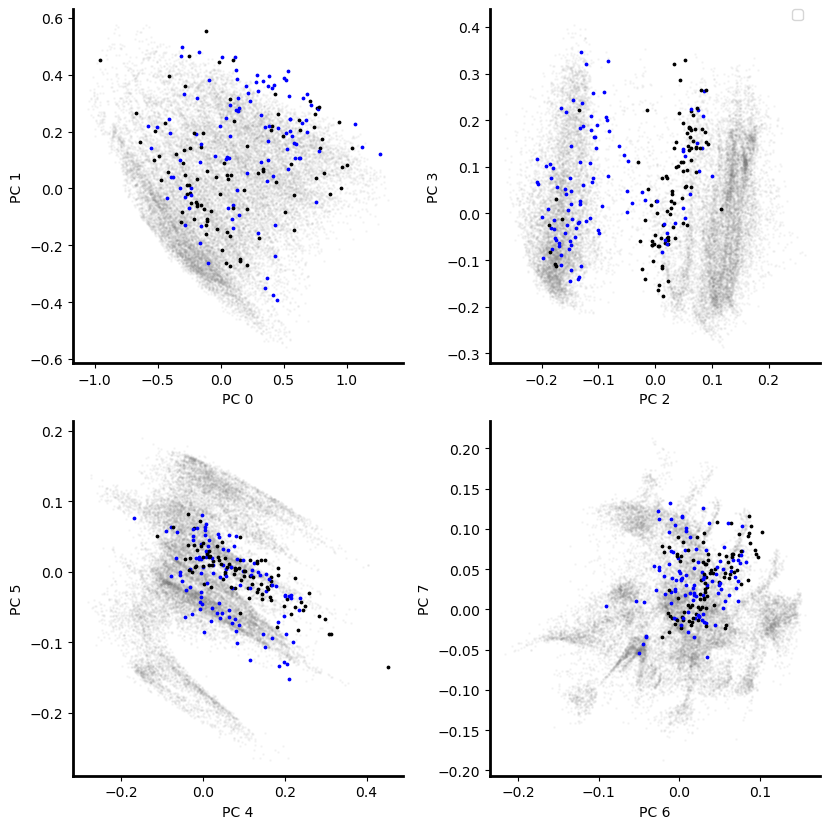

In [7]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :],
        pc_activities[k+1, env_idx, :],
        s=1,
        zorder=-1,
        c='grey',
        alpha=0.05,
    )

    for i_states in range(initial_states.shape[0]):
        it = initial_states[i_states, :]

        # axs[k_x, k_y].scatter(
        #     [np.dot(it, pca.components_[k, :])],
        #     [np.dot(it, pca.components_[k+1, :])],
        #     color = 'green',
        #     zorder=1
        # )

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) < 1.0)
        axs[k_x, k_y].scatter(
            [np.dot(fp.xstar, pca.components_[k, :])],
            [np.dot(fp.xstar, pca.components_[k+1, :])],
            color = 'black' if stable else 'blue',
            s=3,
        )
    
    axs[k_x, k_y].set_xlabel(f'PC {k}')
    axs[k_x, k_y].set_ylabel(f'PC {k+1}')

    # Hide the top and right spines for a cleaner look
    axs[k_x, k_y].spines['top'].set_visible(False)
    axs[k_x, k_y].spines['right'].set_visible(False)

    # Thicken the axes lines (left, bottom)
    axs[k_x, k_y].spines['left'].set_linewidth(2)
    axs[k_x, k_y].spines['bottom'].set_linewidth(2)
    # axs[int(k/2)].set_aspect('equal')
fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
fig.tight_layout()